In [1]:
import urllib.request
import io, os
import zipfile
import pandas as pd
import numpy as np
import xarray as xr
import warnings
import tempfile
from itables import init_notebook_mode, show


In [2]:
EYE2SKY_BASE_URL = "https://zenodo.org/records/12804613/files"

### List of stations


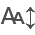

In [3]:
init_notebook_mode(all_interactive=False)

url = os.path.join(EYE2SKY_BASE_URL, 'Eye2Sky_Station_List.xlsx')

try:
     remote = urllib.request.urlopen(url)

     stations = pd.read_excel(io.BytesIO(remote.read()))

     show(stations, scrollY="500px", scrollCollapse=False, paging=False, classes="display",
          order=[[0, "asc"]], showIndex=False, columnDefs=[{"className": "dt-left", "targets": "_all"}])
     
except urllib.error.HTTPError as e:
     if 'not found' in e.msg.lower():
          warnings.warn(f'File {url} was not found.')
     else:
          raise

In [4]:
stations

,Station ID,Place,Domain,Type,Latitude,Longitude,Elevation,Height above ground,Altitude (above sea level),Installation date
0,OLWIN,Oldenburg,Urban,REF,53.153478,8.161923,21,15,6,2019-06-25
1,OLUOL,Oldenburg,Urban,MET,53.153478,8.161923,21,15,6,2019-10-24
2,OLDLR,Oldenburg,Urban,MET,53.151372,8.167010,21,9,12,2021-06-24
3,CDLRA,Oldenburg,Urban,CEI,53.151372,8.167010,21,9,12,2018-04-03
4,OLCLO,Oldenburg,Urban,MET,53.112004,8.210042,22,14,8,2018-11-09
5,OLDON,Oldenburg,Urban,MET,53.146370,8.217330,28,20,8,2018-09-26
6,PVAMM,Metjendorf,Urban,MET,53.181600,8.145600,11,2,9,2019-10-15
7,OLTWE,Oldenburg,Urban,ASI,53.115019,8.261720,16,7,9,2021-09-14
8,OLEMS,Oldenburg,Urban,ASI,53.130210,8.154720,20,12,8,2019-12-10
9,OLBFE,Oldenburg,Urban,ASI,53.149212,8.232014,22,14,8,2020-02-03


In [5]:
import folium
from folium import plugins

EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
EsriAttribution = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"

# Create Folium map
m = folium.Map(
    location=[53.23, 7.8],
    zoom_start=9, min_zoom=7, max_bounds=True,
    control_scale=True,  # Adds distance scale in lower left corner
    tiles='openstreetmap',
)

# Add each station to the map
for index, row in stations.iterrows():
    if 'MET' in row['Type']:
        c = "orange"
        r = 5
    elif 'REF' in row['Type']:
        c = "green"
        r = 7
    else:
        c = "blue" 
        r = 4
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        tooltip=f"ID: {row['Station ID']} - Type: {row['Type']}",
        color=c,
        radius=r).add_to(m)

folium.raster_layers.TileLayer(EsriImagery, name='World imagery', attr=EsriAttribution, show=False).add_to(m)
folium.LayerControl(position='topright').add_to(m)
folium.LatLngPopup().add_to(m)  # Show latitude/longitude when clicking on the map
plugins.Fullscreen(position='bottomright').add_to(m)  # Add full screen button to map

m

In [6]:
METEO_ZIP = os.path.join(EYE2SKY_BASE_URL, '{station}.zip')
FILE_FORMAT = "data/{station}.{type}.nc"


def get_eye2sky(station, start, end, type="cleaned"):
    """
    Retrieve ground measured meteorological and solar irradiance data from the Eye2sky network. [1]_

    The Eye2Sky network consists of 29 all-sky imager stations of which 12 are equipped 
    with meteorological sensors in the north west of Germany. Instrumentation at stations vary, 
    while all measure global horizontal irradiance, tilted irradiance as well as temperature and humidity.
    Several stations measure diffuse horizontal and direct normal irradiance with a rotating shadowband irradiometer.
    Two Tier 1 stations have solar trackers measuring global, direct and diffuse irradiance with thermopile sensors.

    Data is provided in two ways:
    1. Raw data including quality flags from an own quality control
    2. Cleaned data with data failing during the quality control removed

    Additionally, clear sky irradiance data and relative solar positions used for the QC are provided.

    Temporal resolution is 1 minute.
    
    Data is available from Zenodo [2]_.

    Parameters
    ----------
    station: str
        Station ID (5-digit ID). All stations can be requested by specifying
        station='all'.
    start: datetime-like
        First day of the requested period
    end: datetime-like
        Last day of the requested period
    type: str
        Data version: "flagged" (L0 - raw + flags) or "cleaned" (L1 - based on QC)
        Default: cleaned

    Returns
    -------
    data: xarray Dataset
        Dataset of timeseries data from the Eye2Sky measurement network.

    Warns
    -----
    UserWarning
        If one or more requested files are missing a UserWarning is returned.


    Examples
    --------
    >>> # Retrieve 2 weeks of data from Eye2Sky station OLWIN
    >>> data = get_eye2sky('OLWIN','2022-05-21','2022-07-21', type="cleaned")  # doctest: +SKIP

    References
    ----------
    .. [1] `Schmidt, Thomas; Stührenberg, Jonas; Blum, Niklas; Lezaca, Jorge; Hammer, Annette; Vogt, Thomas (2022)
            A network of all sky imagers (ASI) enabling accurate and high-resolution very short-term forecasts of solar irradiance**. 
            In: Wind & Solar Integration Workshop. IET Digital Library. 21st Wind & Solar Integration Workshop, 12.14. Okt. 2022, The Hague, Netherlands. 
            DOI: 
            <https://doi.org/10.1049/icp.2022.2778/>`_ 
    .. [2] `Zenodo
       <https://zenodo.org/records/12804613>`_ 
    """  

    if station == "all":
        stns = []
        for id, stn in stations.iterrows():
            if stn['Type'] in ["MET","REF"] and stn['Station ID'] != 'OLDLR':
                stns.append(stn['Station ID'])
    else:
        stns = [station]


    data = {}
    for stn in stns:
    
        # Generate URL to the ZIP archive
        url = f"{METEO_ZIP.format(station=stn)}?download=1"
        try:
            remotezip = urllib.request.urlopen(url)
        except urllib.error.HTTPError as e:
            if 'not found' in e.msg.lower():
                warnings.warn(f'File {url} was not found.')
                continue
            else:
                raise
        zipinmemory = io.BytesIO(remotezip.read())
        zip = zipfile.ZipFile(zipinmemory)

        filename = FILE_FORMAT.format(station=stn, type=type)
        with tempfile.NamedTemporaryFile(suffix=".nc") as f:
            f.write(zip.read(filename))
            ds = xr.load_dataset(f.name).sel(time=slice(start,end))
            # Add dataset to list
            data[stn] = ds

    return data

In [7]:
data = get_eye2sky('all','2022-07-21','2022-07-25', type="cleaned")

### What is returned?

In [8]:
# Available stations
print(data.keys())

dict_keys(['OLWIN', 'OLUOL', 'OLCLO', 'OLDON', 'PVAMM', 'WITTM', 'WESTE', 'LEEER', 'PVNOR', 'OLJET'])


In [9]:
# The datasets per station
data['OLDON']

<xarray.Dataset> Size: 749kB
Dimensions:       (time: 7200)
Coordinates:
  * time          (time) datetime64[ns] 58kB 2022-07-21 ... 2022-07-25T23:59:00
    latitude      float64 8B 53.15
    longitude     float64 8B 8.217
    elevation     int64 8B 20
Data variables: (12/14)
    GTI_30_180    (time) float64 58kB -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
    cDNI          (time) float64 58kB -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
    RH            (time) float64 58kB 76.9 76.9 76.9 77.0 ... 81.5 81.6 81.6
    cGHI          (time) float64 58kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    turbidity     (time) float64 58kB 3.629 3.629 3.629 ... 3.661 3.661 3.661
    SAZ           (time) float64 58kB 6.453 6.696 6.939 ... 5.744 5.991 6.237
    ...            ...
    T             (time) float64 58kB 21.2 21.2 21.2 21.2 ... 18.8 18.8 18.8
    DHI           (time) float64 58kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cDHI          (time) float64 58kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SZA           (time) float64 58kB 106.1 106.1 106.1 ... 107.2 107.2 107.1
    station_name  <U5 20B 'OLDON'
    crs           int64 8B -999
Attributes: (12/36)
    grid_mapping_name:            latitude_longitude
    longitude_of_prime_meridian:  0.0
    semi_major_axis:              6378137.0
    inverse_flattening:           298.257223563
    epsg_code:                    EPSG:4326
    title:                        Timeseries of solar irradiance and meteorol...
    ...                           ...
    height:                       20
    license:                      https://cdla.dev/sharing-1-0/
    qc_level:                     quality controlled + cleaned data
    surface_type:                 asphalt
    topography_type:              flat
    rural_urban:                  urban

### Data attributes

In [10]:
data['OLDON'].attrs

{'grid_mapping_name': 'latitude_longitude',
 'longitude_of_prime_meridian': '0.0',
 'semi_major_axis': '6378137.0',
 'inverse_flattening': '298.257223563',
 'epsg_code': 'EPSG:4326',
 'title': 'Timeseries of solar irradiance and meteorological measurements in Eye2Sky network from station: OLDON',
 'summary': 'Measurements from ground-based instruments from the Eye2Sky network. The network is operated by DLR Institute of Networked Energy Systems in Oldenburg. First stations are measuring since 2018.',
 'keywords': 'solar irradiance, air temperature, relative humidity, meteorology, atmospheric radiation, measurement station',
 'featureType': 'timeSeries',
 'network_id': 'Eye2Sky',
 'platform': 'Eye2Sky',
 'network_region': 'North-West Germany',
 'station_country': 'Germany',
 'creator_name': 'Jonas Stührenberg (jonas.stuehrenberg@dlr.de)',
 'publisher_email': 'jonas.stuehrenberg@dlr.de,th.schmidt@dlr.de',
 'publisher_name': 'Thomas Schmidt',
 'publisher_institution': 'DLR Deutsches Luft-

### Which variables exist?

In [11]:
print(data["OLDON"].variables)


Frozen({'GTI_30_180': <xarray.Variable (time: 7200)> Size: 58kB
array([-0., -0., -0., ..., -0., -0., -0.])
Attributes: (12/16)
    DIMENSION_LABELS:  time
    orig_name:         plane-of-array irradiance measured with photodiode pyr...
    interval_type:     left_closed/right_open/label_right
    meas_type:         avg
    sensor_brand:      LI-COR
    sensor_model:      LI-200R
    ...                ...
    abbreviation:      GTI_30_180
    _valid_min_:       0.0
    _valid_max_:       3000
    grid_mapping:      crs
    tilt:              30
    azimuth:           180, 'cDNI': <xarray.Variable (time: 7200)> Size: 58kB
array([-0., -0., -0., ..., -0., -0., -0.])
Attributes:
    DIMENSION_LABELS:  time
    long_name:         modelled clear sky direct normal irradiance
    standard_name:     clear_sky_dni
    abbreviation:      cDNI
    units:             W m-2
    _valid_min_:       0
    _valid_max_:       3000
    grid_mapping:      crs, 'RH': <xarray.Variable (time: 7200)> Size: 58k

In [12]:
data['LEEER']['GHI'].attrs

{'DIMENSION_LABELS': 'time',
 'orig_name': 'reference pyranometer, corrected with RSI formula',
 'interval_type': 'left_closed/right_open/label_right',
 'meas_type': 'avg',
 'sensor_brand': 'LI-COR',
 'sensor_model': 'LI-200',
 'sensor_type': 'photodiode',
 'long_name': 'Global Horizontal Irradiance',
 'standard_name': 'surface_downwelling_shortwave_flux_in_air',
 'abbreviation': 'GHI',
 'units': 'W m-2',
 'valid_min_': 0.0,
 'valid_max_': 3000,
 'grid_mapping': 'crs'}

### Export station meta list according to solarstations.org

In [13]:
meta_list = [] 
wrapper_inst = {
    'GHI': 'G',
    'DNI': 'B',
    'DHI': 'D',
}

for stn in data.keys():

    inst = []
    if 'GHI' in data[stn].variables:
        if  data[stn]['GHI'].attrs['sensor_model'] == 'LI-200':
            inst.append('RSI')
        else:
            inst.append('G')
            if 'DNI' in data[stn].variables: inst.append('B')
            if 'DHI' in data[stn].variables: inst.append('D')
    
    if 'GTI' in data[stn].variables:
        inst.append('PAR')
        print(data[stn]['GTI'].attrs())

    inst_date = stations.loc[stations['Station ID'] == stn]['Installation date']

    meta_list.append({ 
        'Station name': data[stn].attrs['station_id'],
        'Abbreviation': data[stn].attrs['station_id'],
        'State': 'Lower Saxony',
        'Country': data[stn].attrs['station_country'],
        'Latitude': data[stn].attrs['latitude'],
        'Longitude': data[stn].attrs['longitude'],
        'Elevation': data[stn].attrs['elevation'],
        'Time Period': f'{inst_date.item():%Y}-',
        'Network':  data[stn].attrs['network_id'],
        'Owner': data[stn].attrs['publisher_institution'],
        'Comment': 'Additional measurements of Temp,rH, GTI and PAR (tilted, upon request) available.',
        'URL': "https://zenodo.org/records/12804613",
        'Data Availability': '1 year public. More data on request',
        'Instrumentation': ';'.join(inst)

    })   
pd.DataFrame(meta_list)

,Station name,Abbreviation,State,Country,Latitude,Longitude,Elevation,Time Period,Network,Owner,Comment,URL,Data Availability,Instrumentation
0,OLWIN,OLWIN,Lower Saxony,Germany,53.15348,8.16192,21,2019-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,G;B;D
1,OLUOL,OLUOL,Lower Saxony,Germany,53.15348,8.16192,21,2019-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,RSI
2,OLCLO,OLCLO,Lower Saxony,Germany,53.11200,8.21004,22,2018-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,RSI
3,OLDON,OLDON,Lower Saxony,Germany,53.14637,8.21733,28,2018-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,RSI
4,PVAMM,PVAMM,Lower Saxony,Germany,53.18160,8.14560,9,2019-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,G
5,WITTM,WITTM,Lower Saxony,Germany,53.57694,7.76241,8,2022-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,RSI
6,WESTE,WESTE,Lower Saxony,Germany,53.25335,7.92658,19,2020-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,RSI
7,LEEER,LEEER,Lower Saxony,Germany,53.14921,8.23201,22,2019-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,RSI
8,PVNOR,PVNOR,Lower Saxony,Germany,53.57749,7.23156,2,2019-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,RSI
9,OLJET,OLJET,Lower Saxony,Germany,53.12040,8.09583,17,2019-,Eye2Sky,DLR Deutsches Luft- und Raumfahrtzentrum e.V /...,"Additional measurements of Temp,rH, GTI and PA...",https://zenodo.org/records/12804613,1 year public. More data on request,RSI


## Visualize data

### Show GHI of all stations and a single day in one graph

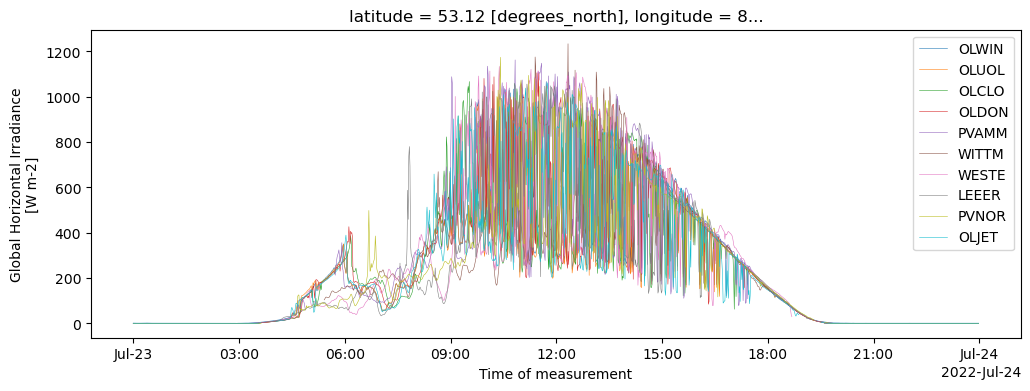

In [26]:
plt.figure(figsize=(12,4)) 
for stn, d in data.items():
    d['GHI'].sel(time='2022-07-23').plot(lw=0.4,label=stn)
plt.legend()
plt.show()

### Show only 2 hours

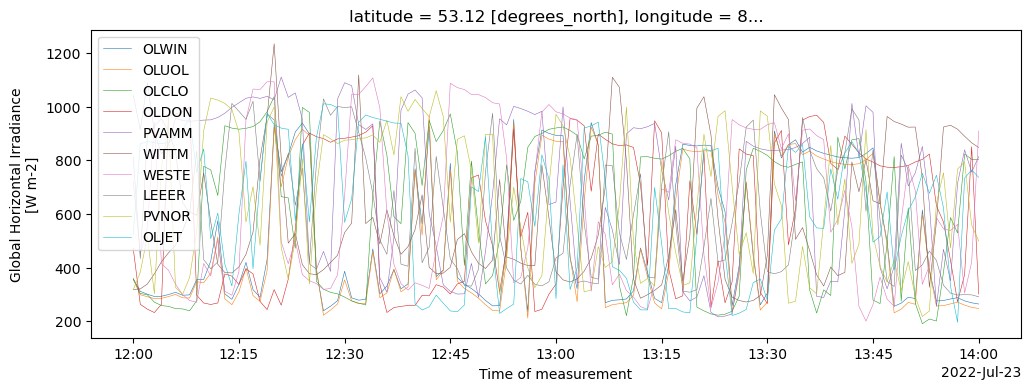

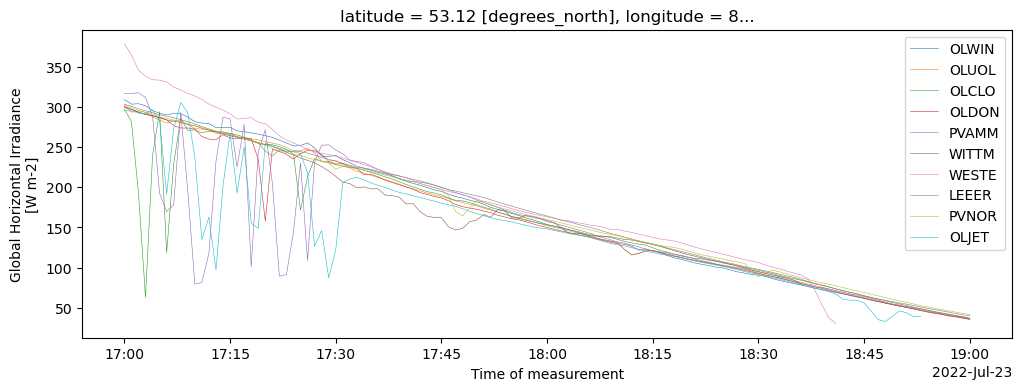

In [27]:
plt.figure(figsize=(12,4)) 
for stn, d in data.items():
    d['GHI'].sel(time=slice('2022-07-23T12:00:00', '2022-07-23T14:00:00')).plot(lw=0.4,label=stn)
plt.legend()
plt.show()

plt.figure(figsize=(12,4)) 
for stn, d in data.items():
    d['GHI'].sel(time=slice('2022-07-23T17:00:00', '2022-07-23T19:00:00')).plot(lw=0.4,label=stn)
plt.legend()
plt.show()

### Show all GTI measurements

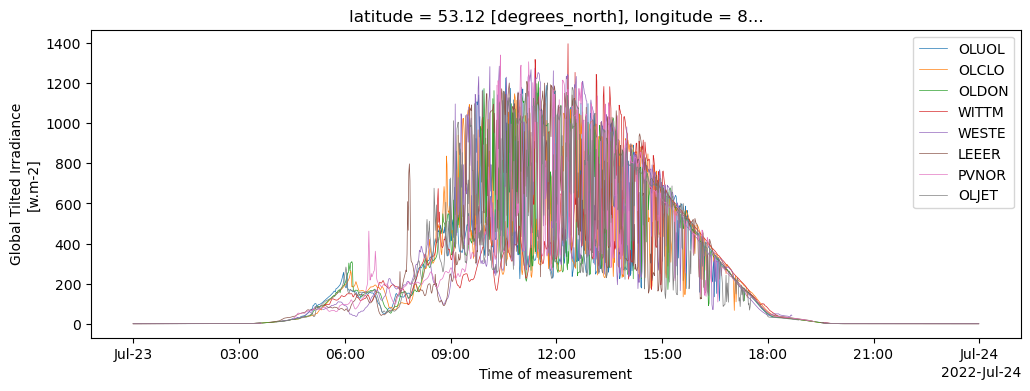

In [28]:
plt.figure(figsize=(12,4)) 
for stn, d in data.items():
    try:
        d['GTI_30_180'].sel(time='2022-07-23').plot(lw=0.5,label=stn)
    except:
        continue
plt.legend()
plt.show()

# The three components of station OLWIN

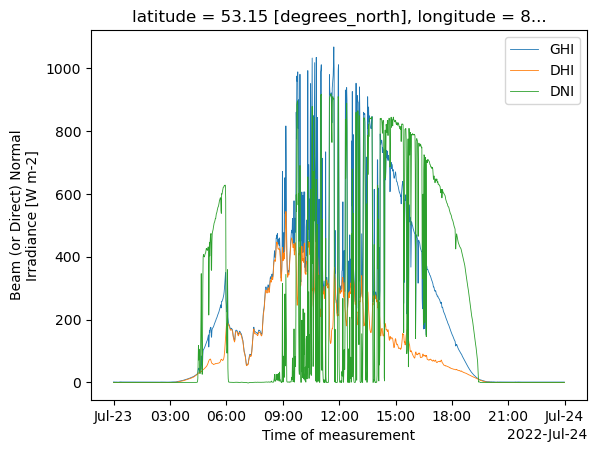

In [38]:
ds = data['OLWIN'].sel(time='2022-07-23')
ds['GHI'].plot(lw=0.6, label="GHI")
ds['DHI'].plot(lw=0.6, label="DHI")
ds['DNI'].plot(lw=0.6, label="DNI")
plt.legend()
plt.show()

### Compare GHI measurements with the sum of diffuse and direct measurements

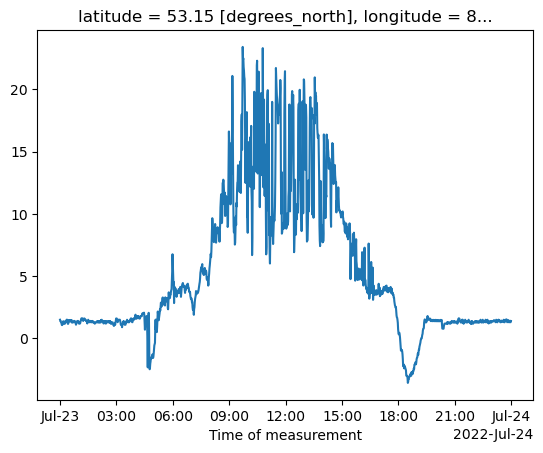

In [16]:
ghi =  data['OLWIN']['GHI'].sel(time='2022-07-23')
dhi =  data['OLWIN']['DHI'].sel(time='2022-07-23')
dni =  data['OLWIN']['DNI'].sel(time='2022-07-23')
solar_zenith = data['OLWIN']['SZA'].sel(time='2022-07-23')
ghi_calc = dhi + dni * np.cos(np.radians(solar_zenith))

(ghi -  ghi_calc).plot()

## Lets have a look in the raw data and QC flags

In [17]:
station = "WITTM"
data = get_eye2sky(station,'2022-07-21','2022-07-25', type="flagged")
par = "DNI"

### See the DNI flags

In [18]:

# Test Names
qc_name = data[station][f'{par}.flag'].attrs['name'].split(',')
# Test Codes 
qc_code = data[station][f'{par}.flag'].attrs['code'].split(',')
# Test actions (how is data that failed tests treated in the cleaned data file)
qc_action = data[station][f'{par}.flag'].attrs['l1_action'].split(',')
# A description / long name of each test
qc_desc = data[station][f'{par}.flag'].attrs['description'].split(',')

tests = pd.DataFrame([qc_name, qc_code, qc_action], index=['Name', 'Code', 'Action'])
show(tests)


### Show the timeseries of flag values

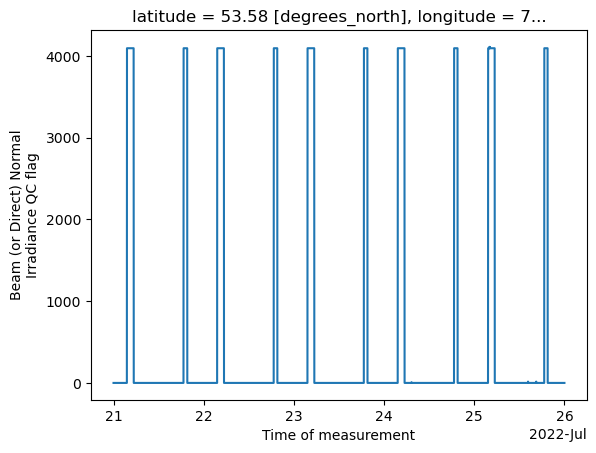

In [19]:
data[station][f'{par}.flag'].plot()

### Decode the Flags and make them human-readable

In [20]:
# This function decodes flag decimal value and returns a dictionary of boolean True/False for each single test
def decoding_flgs(dset, test_names):
    # Number of tests (code 0 == valid is not counting)
    tests = test_names[1:]
    ntests = len(tests)
    dec = np.copy(dset)
    flgs = (np.repeat(np.zeros(ntests), len(dec))).reshape(len(dec), ntests)
    for i in range(0, len(dec)):
        for j in range(0, len(flgs[i])):
            flgs[i][j] = dec[i] % 2
            dec[i] = dec[i] // 2
    df = {}
    for i, col in enumerate(tests):
        df[col] = flgs[:,i].astype(bool)
    return df

In [21]:
# Decode also the .test variable. It contains information if the test has been applied to the parameter or not
ds = data[station]
flags = ds[f'{par}.flag']
tests = ds[f'{par}.test']
tests = decoding_flgs(tests, qc_desc)
flags = decoding_flgs(flags, qc_desc)

### Print some statistics

In [22]:
# Print statistics
for key, value in flags.items():
    # only if test has been applied
    if all(tests[key]):
        if any(value):
            # Check for flags
            ind = value == True
            # Check for consecutive flags (-> periods)
            ind = np.diff(ind,prepend=False)
            periods = ds['time'][ind].values.reshape(int(np.sum(ind)/2),2)
            print(f'QC failed for test "{key}"')
            print(f'Number of data points {len(periods)} ({100*len(periods)/len(ds['time']):.2f} %)')
            #for i in range(periods.shape[0]):

QC failed for test "tracking error"
Number of data points 1 (0.01 %)
QC failed for test "two redundant measurements deviate from each other"
Number of data points 5 (0.07 %)
QC failed for test "shading based on horizon file"
Number of data points 10 (0.14 %)


### Make a plot for each single test

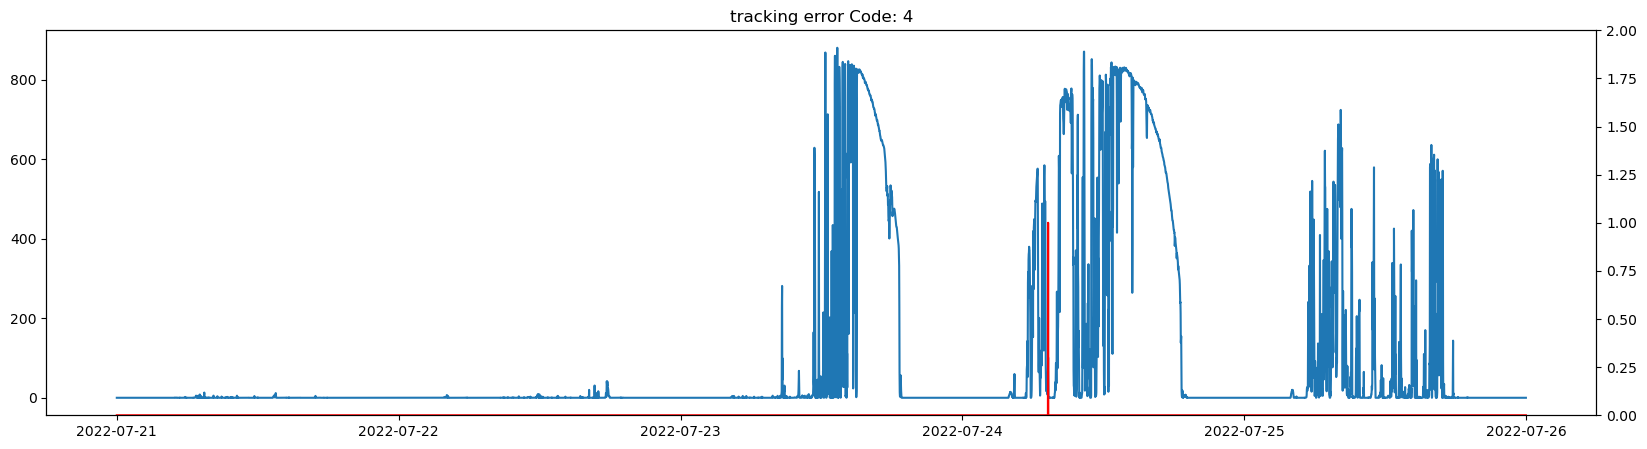

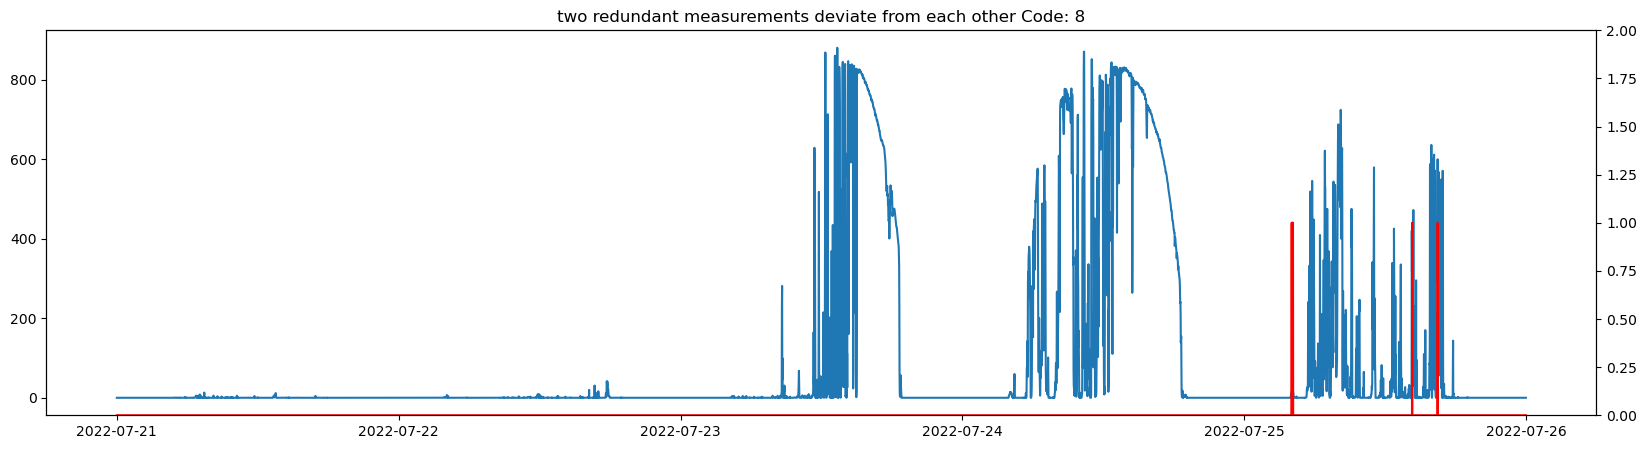

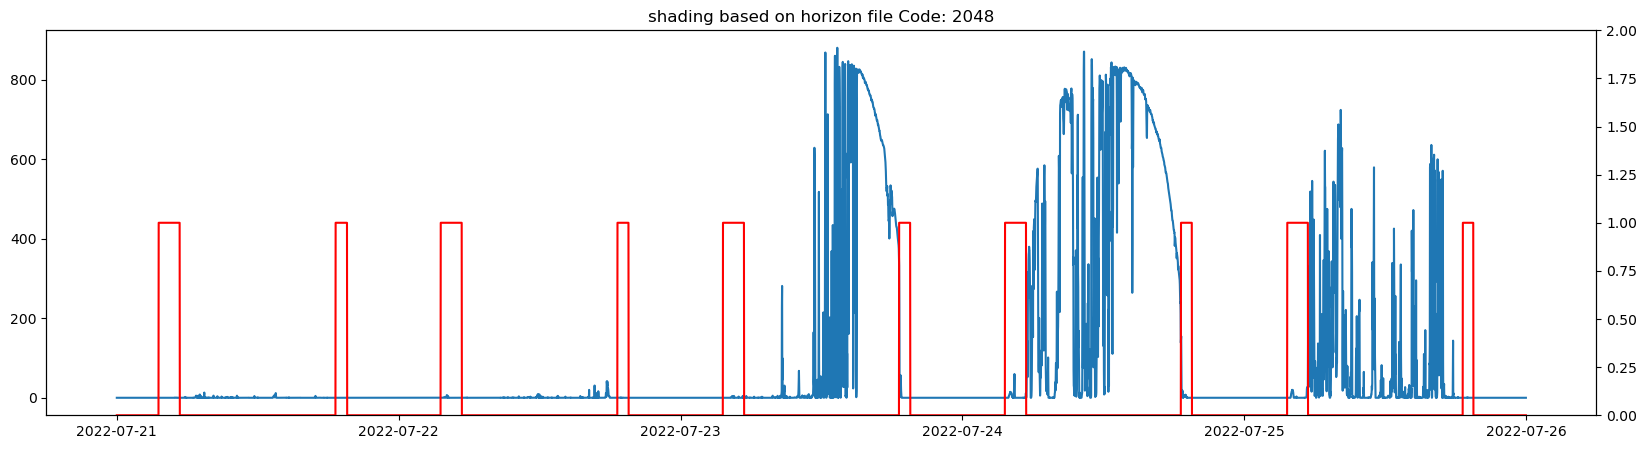

In [23]:
# Plot graphs
import matplotlib.pyplot as plt
for idx, (key, value) in enumerate(flags.items()):
    if all(tests[key]):
        if any(value):
            fig, ax = plt.subplots(figsize=(20,5))
            ax2 = ax.twinx()
            ax.plot(ds['time'],ds[par])
            ax2.plot(ds['time'],value, c="r")
            ax2.set_ylim(0,2)
            plt.title(f'{key} Code: {qc_code[idx]}')
            plt.show()